# Supervised Representation Learning 

In this tutorial we show how to perform supervised representation learning on CWRU dataset.

In [1]:
%xmode minimal

from pathlib import Path
import os

# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"
os.environ["KERAS_BACKEND"] = "tensorflow"

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

# Turn off logging for TF
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds
tf.get_logger().setLevel(logging.ERROR)

# import librosa
# import librosa.display
# from IPython.display import Audio

import numpy as np
from matplotlib import pyplot as plt

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import keras
from keras import layers, models, ops, losses, metrics
# from keras.applications import resnet, vgg16

# tf.config.experimental_run_functions_eagerly(True)
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Exception reporting mode: Minimal


In [2]:
import dpmhm
# dpmhm.datasets.get_dataset_list()

from dpmhm.datasets import preprocessing, feature, utils, transformer, query_parameters

In [4]:
outdir = Path(os.path.expanduser('~/dpmhm/cwru'))
os.makedirs(outdir, exist_ok=True)

## Load the CWRU dataset

We use the CWRU dataset for this tutorial. Suppose it has been correctly installed. We load it using the method `tfds.load()`.

In [6]:
ds0, ds_info = tfds.load(
    'CWRU',
    split='all',
    with_info=True,
)

ds_parms = query_parameters('CWRU')
print(ds_parms)

{'signal': {'DE': 1, 'FE': 1, 'BA': 1}, 'sampling_rate': [12000, 48000], 'keys': {'FaultLocation': {'FanEnd', 'None', 'DriveEnd'}, 'FaultComponent': {'None', 'InnerRace', 'OuterRace6', 'OuterRace12', 'Ball', 'OuterRace3'}, 'FaultSize': {0, 0.007, 0.014, 0.028, 0.021}}, 'filters': {'LoadForce': {0, 1, 2, 3}}, 'type': 'initiated', 'split': ['train']}


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='cwru',
    full_name='cwru/1.0.0',
    description="""
    Case Western Reserve University bearing dataset.
    
    Description
    Motor bearings were seeded with faults using electro-discharge machining (EDM). Faults ranging from 0.007 inches in diameter to 0.040 inches in diameter were introduced separately at the inner raceway, rolling element (i.e. ball) and outer raceway. Faulted bearings were reinstalled into the test motor and vibration data was recorded for motor loads of 0 to 3 horsepower (motor speeds of 1797 to 1720 RPM).
    
    Further Information
    -------------------
    Two possible locations of bearings in the test rig: namely the drive-end and the fan-end.
    
    For one location, a fault of certain diameter is introduced at one of the three components: inner race, ball, outer race. The inner race and the ball are rolling elements thus the fault does not have a fixed position, while the outer race is a fixed frame and the fault 

### Preprocessing pipeline

Next let's define a preprocessing pipeline consisting of
- selecting data files that contain simultaneously all 3 channels & label ramification
- feature extraction: compute the spectrogram
- sliding window view that yields patches of fixed dimension

In [31]:
rsr = 12000  # resampling rate

compactor = transformer.DatasetCompactor(
    ds0,
    channels=list(ds_parms['signal'].keys()), # select all channels simultaneously
    keys=list(ds_parms['keys'].keys()),    
    resampling_rate=rsr,
    # split=True,  # split multidimensional signals into 1d signals, incompatible with the pretrained VGGish model
)

# Feature extractor
# Spectrogram is computed on a time window of 0.025 second every 0.0125 second, then converted to decibel scale.
tw, hs = 0.025, 0.0125
nf = int(2**(np.ceil(np.log2(rsr*tw))))

_func = lambda x, sr: feature.spectral_features(
    x, sr, 'spectrogram',
    # n_mfcc=256,
    time_window=tw, hop_step=hs, 
    n_fft=nf,
    normalize=True, to_db=True)[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# A window of width w correspond to w*0.0125 seconds
# window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))
window = transformer.WindowSlider(extractor.dataset, window_size=80, hop_size=40)  # 1s, full bandwidth

# compactor.dataset.element_spec

In [35]:
ele = list(window.dataset.take(1))[0]
print(ele['feature'].shape)

(3, 257, 80)


Print the dictionary of all labels

In [36]:
labels = list(compactor.full_label_dict.keys())  # need the whole list of labels
print("Number of classes:", len(labels))

compactor.full_label_dict
# compactor.label_dict

Number of classes: 29


{'7f67e45381c3652c': ['FanEnd', 'OuterRace3', '0.014'],
 '8b9e80c02e1fca5b': ['FanEnd', 'OuterRace6', '0.007'],
 'd766ecd2592ce5ec': ['DriveEnd', 'Ball', '0.021'],
 'e27e22f1f5037a20': ['DriveEnd', 'InnerRace', '0.014'],
 '8af14bb8ad669337': ['FanEnd', 'OuterRace12', '0.007'],
 '2533c59036dfe8c8': ['FanEnd', 'InnerRace', '0.007'],
 'd6765bfdf1aca38f': ['DriveEnd', 'Ball', '0.007'],
 'a760eef52ceaa6f9': ['FanEnd', 'OuterRace3', '0.021'],
 'dc8bcb86c369e78b': ['FanEnd', 'InnerRace', '0.021'],
 '9c54396620a4b6a3': ['DriveEnd', 'OuterRace6', '0.021'],
 'b0a92d9d7379d8ce': ['DriveEnd', 'InnerRace', '0.007'],
 '60836667e7ee1dec': ['FanEnd', 'OuterRace3', '0.007'],
 '1c80dbfc87966d6e': ['FanEnd', 'InnerRace', '0.014'],
 'd8957867a1fc0519': ['DriveEnd', 'OuterRace3', '0.007'],
 '605222dceca4b27e': ['FanEnd', 'Ball', '0.021'],
 '6c2ba36f712d55e4': ['DriveEnd', 'OuterRace6', '0.014'],
 '55503c950ed81973': ['FanEnd', 'Ball', '0.014'],
 'd45bbeb3b8a72222': ['DriveEnd', 'OuterRace6', '0.007'],
 'f6

Here's how the spectrogram patches look like:

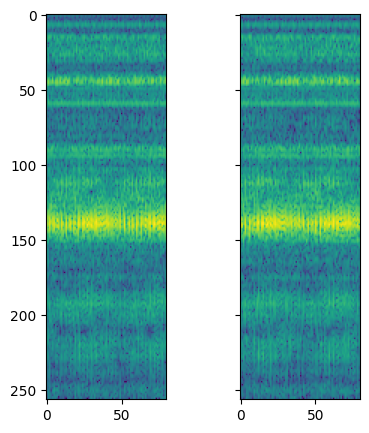

In [64]:
eles = list(window.dataset.take(10).as_numpy_iterator())

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(5,5), sharey=True)

ax1.imshow(eles[0]['feature'][0])
# ax1.set_aspect('equal')
ax2.imshow(eles[9]['feature'][0])
# ax2.set_aspect('equal')

plt.subplots_adjust(wspace=0)
# plt.tight_layout()


As the last step of preprocessing, apply a preprocessing mapping to transform the dataset to the tuple `(feature, label)` compatible for supervised learning, with the field `feature` in the channel-last format. Finally the preprocessed dataset can be exported to disk for reuse.

In [70]:
preproc = preprocessing.get_mapping_supervised(labels)

ds_window = utils.restore_shape(
    window.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE),
    key=0
)
ds_size = utils.get_dataset_size(ds_window)

# import json
# with open(outdir/'labels.json', 'w') as fp:
#     json.dump(compactor.full_label_dict,fp)
# ds_window.save(str(outdir/'cwru'))

### Load the preprocessed dataset

The preprocessed dataset can be loaded from the disk.

In [41]:
ds_window = tf.data.Dataset.load(str(outdir/'cwru'))
ds_size = ds_window.cardinality()

with open(outdir/'labels.json', 'r') as fp:
    labels = list(json.load(fp).keys())

In [71]:
print(f"Total number of elements: {ds_window.cardinality()}")
ds_window.element_spec

Total number of elements: -2


(TensorSpec(shape=(257, 80, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Train a VGGish network

Note that the Keras preprocessing model included an outlier class (of label `0`) in the final dataset, we must accordingly increase the number of classes by 1.

In [72]:
# eles = list(ds_window.take(1).as_numpy_iterator())
# input_shape = eles[0][0].shape
input_shape = ds_window.element_spec[0].shape

n_classes = len(labels)+1  # must add one for the outlier class, Keras uses zero-based class labels.
print(f"Number of class: {n_classes}")

splits = {'train':0.7, 'val':0.2, 'test':0.1}
ds_split = utils.split_dataset(ds_window, splits, ds_size=ds_size)

Number of class: 30


Create the training/validation/test set with mini-batches. Notice that the method `.batch()` increases by 1 the rank of the dataset: it is the dimension of the mini-batch.

In [88]:
batch_size = 32

ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).repeat()\
            .batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size, drop_remainder=True)
ds_test = ds_split['test'].batch(1, drop_remainder=True)

ds_train.element_spec

steps = int(np.floor(ds_size * 0.7/batch_size))

### Implementation 1: Keras pretrained model with transfer learning

Keras comes with a VGG16 model pretrained on Imagenet that can be reused for feature embedding. We load and freeze the pretrained weights and perform transfer learning only on final classification layers.

In [ ]:
from keras.applications import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape, classes=n_classes, pooling='avg')

base_model.trainable = False

base_model.summary()

In [79]:
x = layers.Input(input_shape)

# We use a very small classification head and it turns out to be sufficient for the CWRU dataset.
adapt_model = models.Sequential([
    layers.Flatten(name="flatten"),
    # layers.Dense(4096, activation="relu", name="fc1"),
    # layers.Dense(4096, activation="relu", name="fc2"),
    layers.Dense(n_classes, activation=None, name="predictions")
])

y = adapt_model(base_model(x))

# Equivalent:
# x = base_model(x)
# x = layers.Flatten(name="flatten")(x)
# x = layers.Dense(4096, activation="relu", name="fc1")(x)
# x = layers.Dense(4096, activation="relu", name="fc2")(x)
# y = layers.Dense(n_classes, activation=None, name="predictions")(x)

In [80]:
model = models.Model(x, y)

from_logits = 'softmax' not in str(model.layers[-1].get_layer('predictions').activation)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [90]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=2,
    steps_per_epoch=steps,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9976 - loss: 0.2867 - val_accuracy: 0.9115 - val_loss: 0.2634
Epoch 2/2


/home/han/.conda/envs/dev311/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9978 - loss: 0.2693 - val_accuracy: 0.9167 - val_loss: 0.2221


In [93]:
model.evaluate(ds_test)

185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 1.0000 - loss: 0.2508


[0.25220608711242676, 1.0]

#### Fine tuning

After training, we can perform several steps of fine tuning with a small learning rate.

In [94]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [95]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=2,
    steps_per_epoch=steps,    
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.9825 - loss: 0.1234 - val_accuracy: 0.9167 - val_loss: 0.0039
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9167 - val_loss: 0.0012


In [96]:
model.evaluate(ds_test)

185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 1.0000 - loss: 6.3002e-04


[0.0007908727857284248, 1.0]

Visualization of features

In [ ]:
_features = model.predict(ds_window.batch(1))
_labels = list(ds_window.map(lambda x,y: y).as_numpy_iterator())

# _features = model.predict(ds_train)  # Don't use batched data!

from sklearn.manifold import TSNE
# Apply t-SNE to reduce the feature dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=_labels)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE visualization of DNN features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

In [27]:
model.save(str(outdir / 'vggish_model_transfer.keras'))

### Implementation 2: from scratch

We provide an implementation of the VGGish network. Unlike the Keras implementation, weights are not pretrained here so the training may be longer. 

In [49]:
from dpmhm.models.sl import vggish

config = vggish.Config(input_shape=input_shape, n_embedding=128, n_classes=n_classes, padding='same', activation='relu',)
model = vggish.VGG11(config)

print(config)

model.summary()

# l=model.get_layer('classifier')

Config(input_shape=(64, 64, 1), batch_size=256, epochs=100, training_steps=1000, n_classes=30, n_embedding=128, kernel_size=(3, 3), activation='relu', activation_classifier=None, padding='same', pool_size=(2, 2), strides=(2, 2))


Model: "VGGish-A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_1 (Conv2D)                │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_2 (Conv2D)                │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_1 (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_2 (Dense)                   │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,921,630 (133.22 MB)

 Trainable params: 34,921,630 (133.22 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
from_logits = 'softmax' not in str(model.get_layer('classifier').activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [51]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)


Epoch 1/5
1068/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.0490 - loss: 4.1578

2024-06-13 22:31:21.488156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1069/1069 ━━━━━━━━━━━━━━━━━━━━ 702s 655ms/step - accuracy: 0.0491 - loss: 4.1562 - val_accuracy: 0.1702 - val_loss: 2.6486
Epoch 2/5


2024-06-13 22:31:56.031446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  19/1069 ━━━━━━━━━━━━━━━━━━━━ 10:47 617ms/step - accuracy: 0.1712 - loss: 2.7256

KeyboardInterrupt: 

In [25]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)


Epoch 1/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 192s 537ms/step - accuracy: 0.9153 - loss: 0.3731 - val_accuracy: 0.9368 - val_loss: 0.2900
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 190s 532ms/step - accuracy: 0.9170 - loss: 0.4103 - val_accuracy: 0.9810 - val_loss: 0.0912
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 192s 537ms/step - accuracy: 0.9695 - loss: 0.1564 - val_accuracy: 0.8846 - val_loss: 0.4811
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 188s 528ms/step - accuracy: 0.8788 - loss: 0.5810 - val_accuracy: 0.9712 - val_loss: 0.1216
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 188s 526ms/step - accuracy: 0.9617 - loss: 0.1724 - val_accuracy: 0.9537 - val_loss: 0.2963
Epoch 5: early stopping


In [26]:
model.evaluate(ds_test)

1630/1630 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9563 - loss: 0.3218


[0.26855865120887756, 0.9527607560157776]

In [27]:
model.save(str(outdir / 'vggish_model_scratch.keras'))

# EOF